In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Reducing the dimensions of your training data will make training your model faster and it will make it easier to visualize your data. It *can* make your model perform better but that is usually not the case overall. 

# The Curse of Dimensionality

Since we're so accustomed to living in a three-dimensional world, our intuition usually fails us when we consider higher dimension data sets. 

High dimension data sets are very sparse. Making predictions on such sets thus requires much more extrapolations which in turn make it more likely to overfit the data. 

# Main Approaches for Dimensionality Reduction

## *Projection*

In real world problems, not all dimensions contain important information nor do they always contain an equal amount of data. Thus all training instances may exist in a *subspace* of the higher dimension space. For example, consider a set of points in a three dimension space that all roughly occupy some xy/yz/xz-plane. In this case, it would be possible to **project** those three-dimensional points onto a two-dimensional subspace.

## *Manifold Learning*

A 2D **manifold** is a 2D shape that can be bent and twisted in a higher-dimension space. Generally, a d-dimension manifold is a part of an n-dimension space, where $d<n$, that locally resembles a d-dimension hyperplane. 

Many dimension reduction algorithms work by modeling the manifold on which the training instances lie (this is called **Manifold Learning**). It is often the case that real world data sets lie close to some lower dimension manifold (**manifold hypothesis**). Consider the MNIST dataset, if you were to randomly generate a similar sized image it would most likely not resemble a written character. Thus becuase the degrees of freedom in a random image of the same size is higher than those of a written character, the MNIST dataset must be on some lower dimension manifold. 

# PCA

**Principle Component Analysis** (PCA) identifies the hyperplane that lies closest to the input data and then projects the data onto it. 

## *Preserving the Variance*

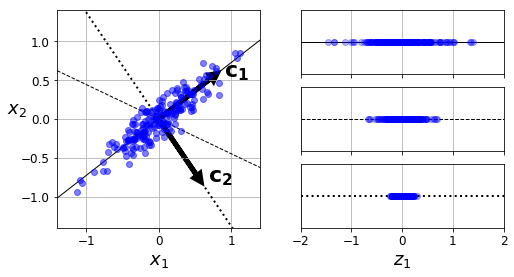

In [2]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)
plt.show()

Before projecting data, a hyperplan must be chosen. On the LHS of the figure is a 2D dataset and on the RHS is the projection of that set onto three different axis. In order to preserve the total amount of information, in this case it would make sense to project the data onto the solid line. This projection also preserves the most *variance* of the dataset. 

## *Principle Components*

The unit vector that identifies the $i^{th}$ axis is called the $i^{th}$ **principle component** (PC). PCA identifies the PC with the most variance and designates it as the $1^{st}$ PC and then designates further PCs until it reaches the desired dimension the user wants the data reduced to. In the figure above $c_1 \,\&\, c_2$ represent the first and second PCs.

**Singular Value Decomposition** is a matrix factorization that can decompose the training set $X$ into the dot product: $X = U \cdot \Sigma \cdot V^T$ where $V^T$ contains all the PCs the algorithm needs. The python code below obtains all the principle components of the training set and then extracts the first two PCs:

In [3]:
X_centered = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X_centered)
c1 = V.T[:,0]
c2 = V.T[:,1]

## *Projecting Down to d-Dimensions*

To project data down to d-dimensions, simply project the data onto the plan defined by the first d PCs in the matrix $V^T$. Use the following equation to do that: $X_{d-proj} = X \cdot W_d$ where $W_d$ is the matrix containing the first d PCs from $V^T$. The following projects our training data to two dimensions.

In [4]:
W2 = V.T[:, :2]
X2D = X_centered.dot(W2)

## *Using Scikit Learn*

Everything we've done in the python code above so far can also be done with Scikit:

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

## *Explained Variance Ratio*

The **explained variance ratio** indicates the proportion of the data's variance that lies along axis of a particular PC. To access this value in Scikit, look in the $explaned\_variance\_ratio\_$ variable. 

## *Choosing the Right Number of Dimensions*

For data visulaization, just reduce down to two or three dimensions. For training reasons, reduce down to a dimension such that the variance of the projected data is equal to $99\%$ of the original data's variance (or any other large percentage).

The following code calculates how many dimensions are required to keep $95\%$ of the training data's variance:

In [7]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

mnist = fetch_mldata('MNIST original')
X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

154

## *PCA for Compression*

PCA can be used to reduce the size of your data. Using PCA on the MNIST dataset, you could reduce the number of features from 784 to 154 while maintaining $95\%$ of the original data's variance. 

Once you've compressed data, it is possible to use a inverse PCA transformation to get some of your original data back. The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called called the **reconstruction error**. The inverse equation is: $X_{recovered} = X_{d-proj} \cdot W_{d}^T$

## *Incremental PCA*

In **Incremental PCA** you use mini-batches of data in order to project down to smaller dimensions rather than processing the entire dataset at one time. 

In [9]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

## *Randomized PCA*

You can use **Randomized PCA** to find a stochastic approximation of the first d PCs. Its complexity depends on d rather than n so it is much faster when $d << n$.

In [10]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

# Kernel PCA

Similar to the kernal trick for Support Vector Machines, the **Kernal PCA** makes it possible to perform complex nonlinear projections for dimensionality reductions. The following is an application of this in Scikit:

In [ ]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

## Selecting a Kernel and Tuning Hyperparameters

Since kPCA is an unsupervised learning algorithm there is no obvious way to find the best kernel automatically. Instead you must try different hyperparameters to find what's best for your situation. The code below creates a pipeline to find the kernel hyperparameters:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

# LLE

**Locally Linear Embedding** (LLE) is a *non-linear dimensionality reduction* (NLDR) technique that works by measuring how much each training instance linearly relates to its closest neighbors and then finding a lower dimension representation where all linear relations are best preserved. 

For each training instance $x^{(i)}$ the LLE algorithm finds its $k$ closest neighbors and then tries to reconstruct $x^{(i)}$ as a linear function of those neighbors. Concretely, it must mininmize: $\Sigma_{j=1}^{m} w_{i,j} \, x^{(j)}$ where $w_{i,j}$ is the weight between two instances and is equal to zero if the instances are the not amongst the $k$ closest neighbors. All of these weights are stored in a matrix $W$. In the next step of LLE these weights are preserved and a lower dimension mapping is found. 

LLE scales poorly: $O(m \,\, log(m)n \,\,log(k))$ to find the k neighbors, $O(mnk^3)$ to optimize the weights, and $O(dm^2)$ for constructing the low dimension representations. 

# Exercises